In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and preprocess data
data_dir = "C:/Users/nani1/OneDrive/Desktop/oral cancer dataset/Oral Cancer"
labels = os.listdir(data_dir)
filepaths = []
for label in labels:
    folder_path = os.path.join(data_dir, label)
    filepaths.extend([os.path.join(folder_path, file) for file in os.listdir(folder_path)])


In [3]:
# Create DataFrame
df = pd.DataFrame({"filepaths": filepaths, "labels": [os.path.basename(os.path.dirname(path)) for path in filepaths]})


In [4]:
# Train-test split
train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(test_df, test_size=1/3, shuffle=True, random_state=123)

In [5]:
# Image parameters
batch_size = 128
img_size = (224, 224)


In [6]:
# Data Generators
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
valid_gen = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7001 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.


In [7]:
# Base model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Custom head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.36),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.36),
    Dense(len(labels), activation='softmax')
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               213120    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               1

In [11]:
# Train the model
history = model.fit(train_gen,
                    epochs=60,
                    validation_data=valid_gen)

Epoch 1/60
55/55 [==============================] - 661s 12s/step - loss: 0.6502 - accuracy: 0.7249 - val_loss: 0.4498 - val_accuracy: 0.7815
Epoch 2/60
55/55 [==============================] - 626s 11s/step - loss: 0.4326 - accuracy: 0.8152 - val_loss: 0.3608 - val_accuracy: 0.8375
Epoch 3/60
55/55 [==============================] - 592s 11s/step - loss: 0.3470 - accuracy: 0.8476 - val_loss: 0.3334 - val_accuracy: 0.8570
Epoch 4/60
55/55 [==============================] - 564s 10s/step - loss: 0.2911 - accuracy: 0.8780 - val_loss: 0.2848 - val_accuracy: 0.8820
Epoch 5/60
55/55 [==============================] - 564s 10s/step - loss: 0.2532 - accuracy: 0.8944 - val_loss: 0.2585 - val_accuracy: 0.8975
Epoch 6/60
55/55 [==============================] - 565s 10s/step - loss: 0.2353 - accuracy: 0.9046 - val_loss: 0.2758 - val_accuracy: 0.8770
Epoch 7/60
55/55 [==============================] - 564s 10s/step - loss: 0.2150 - accuracy: 0.9093 - val_loss: 0.2392 - val_accuracy: 0.9030
Epoch 

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

8/8 [==============================] - 71s 9s/step - loss: 0.2142 - accuracy: 0.9441
Test Loss: 0.214180126786232
Test Accuracy: 0.9440559148788452


In [13]:
# Confusion matrix
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(true_classes, y_pred_classes)

8/8 [==============================] - 70s 8s/step


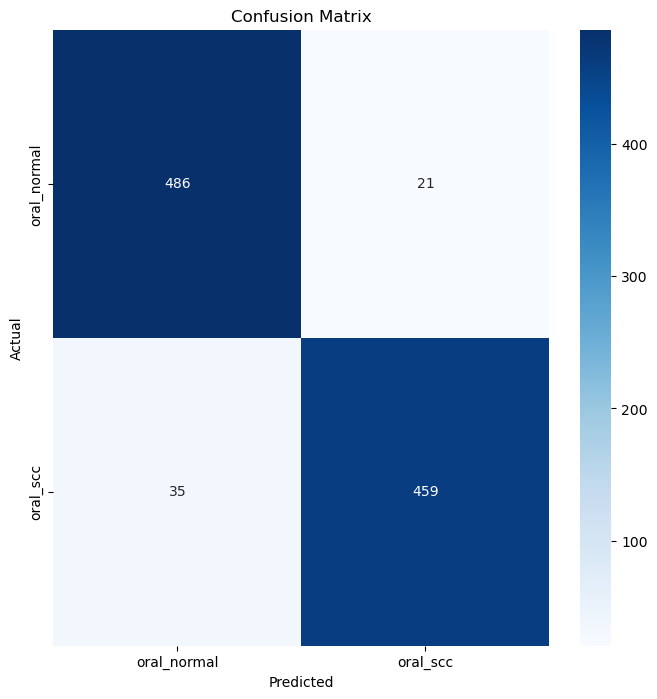

In [14]:
# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

 oral_normal       0.93      0.96      0.95       507
    oral_scc       0.96      0.93      0.94       494

    accuracy                           0.94      1001
   macro avg       0.94      0.94      0.94      1001
weighted avg       0.94      0.94      0.94      1001



In [1]:
model.save(r'C:/Users/nani1/OneDrive/Desktop/Densenet 201/Densenet169.h5')
model1 = tf.keras.models.load_model(r'C:/Users/nani1/OneDrive/Desktop/Densenet 201/Densenet169.h5')

NameError: name 'model' is not defined